In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

from scipy import optimize
from scipy.linalg import toeplitz
from numpy.polynomial import Polynomial

import gradient_code

from utils import color_cycle, plotting_utility

# Lecture 4: Learning in neural netwoks

* **4.1 Gradient-based learning**
    * Logistic regression and multi-class classification
    * Gradient descent, momentum, Newton's method, line search (_bonus: conjugate gradient descent_)
    * Stochastic gradient descent, Robbins-Monro

_Recommended readings and viewing_:
* [Mark Schmidt](https://www.cs.ubc.ca/~schmidtm/) has a number of excellent tutorials and videolectures on optimization and gradient descent. You may want to watch his minicourse [Stochastic Convex Optimization Methods in Machine Learning](https://www.youtube.com/watch?v=p4EnVHSml4U)
* For a introduction to conjugate gradient _without the agonizing pain_: https://people.eecs.berkeley.edu/~jrs/jrspapers.html#cg

## Classification using logistic regression

**Data**: $\mathcal{D}=\{(x^\mu,t^\mu)\} \quad \mu=1,\ldots,P$

* $x^\mu=(x_1^\mu,\ldots,x_N^\mu$) vector of (continuous) $N$-dimensional inputs.
* $t^\mu=0,1$ binary target

The model $$y(x,w)=p(t=1|x,w)$$ represents the probability that $x$ to belongs to class $t=1$. In analogy with the perceptron, we take

$$p(t=1|x,w)=\sigma\left(\sum_{i=0}^N w_i x_i\right)$$

where $x_0=1$, $\sigma$ is the sigmoid function $\sigma(x)=(1+e^{-x})^{-1}$, and obviously $p(t=0|x)=1-y$. We can thus write the likelihood of the outputs in $\mathcal{D}$ as
$$\prod_{\mu=1}^P p(t^\mu|x^\mu,w)=\prod_{\mu=1}^P y(x^\mu,w)^{t^\mu} (1-y(x^\mu,w))^{1-t^\mu}$$

and define the negative log-likelihood of the data as the loss function to be minimized:

$$E(w)=-\sum_{\mu=1}^P\left[t^\mu \log y(x^\mu,w)+(1-t^\mu)\log (1-y(x^\mu,w))\right]$$

When used in a classification context, one uses a threshold (typically 0.5) for the output of the sigmoid function. One may also want to divide $E$ by $P$ for numerical stability in optimization.

## Multi-class classification

For more than two classes, consider a network with $K$ outputs: $t^\mu_k=1$ if $x^\mu$ belongs to class $k$ and $t^\mu_k=0$ otherwise (_one-hot encoding_).

The network output is

$$y_k(x^\mu,w_k) \qquad k=1,\ldots, K$$

Define the probability vector:
$$p_k(x,\{w_k\})= \frac{\exp\left[y_k(x,w_k)\right]}{\sum_{k'=1}^K \exp\left[y_{k'}(x,w_{k'})\right]}$$

The maximum likelihood objective becomes:
$$L(w) = \prod_{\mu=1}^P \prod_{k=1}^K p_k(x^\mu,\{w_k\})^{t_k^\mu} \qquad \leftrightarrow \qquad E(w)=-\sum_{\mu=1}^P\sum_{k=1}^K t_k^\mu \log p_k(x^\mu,\{w_k\})$$

#### Example: the Softmax function

In [21]:
# define your own Softmax
def softmax(h, beta = 1.):
    Z = np.exp(beta * h).sum()
    return np.exp(beta * h) / Z

In [22]:
# generate random data and weights
N = 50
K = 10

np.random.seed(3)
x = np.random.randn(N)
W = np.random.randn(K,N) / np.sqrt(N)

y = W @ x

In [ ]:
# compute softmax output for different 'inverse temperature' values
beta = 1. # try 1., 10., 100.
p = softmax(y, beta=beta)

plt.plot(y, '.-', label='y')
plt.plot(p, '.-', label=f'p, beta = {beta}')
plt.legend();

## Parameter optimization

In order to minimize $E$, we will look for stationary points, i.e. $\nabla E(w)=0$. $E$ is minimal when $\nabla E(w)=0$, but not vice versa!

As a consequence, gradient-based methods find a **local minimum**, not necessarily the global minimum.

In [27]:
# generate random landscape (through a stationary Gaussian process for simplicity)
np.random.seed(1)

lin_shape = 50
x = np.linspace(0,1,lin_shape)
cov_lin = np.exp(-0.5/0.1**2*x**2)
C = np.kron(toeplitz(cov_lin), toeplitz(cov_lin))

E = np.random.multivariate_normal(mean=np.zeros(lin_shape**2), cov=C).reshape(lin_shape,lin_shape)

In [ ]:
# plot
X, Y = np.meshgrid(x,x)
ax = plt.figure().add_subplot(projection='3d')
ax.plot_surface(X, Y, E, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8, alpha=0.4)
ax.contour(X, Y, E, zdir='z', offset=-5, cmap='coolwarm')
ax.set(zlim=(-5, 5))

plt.show()

In [ ]:
# another look at the random surface
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(E, cmap='coolwarm')
plt.hlines(y=20, xmin=0, xmax=lin_shape-1, color='black', alpha=0.5)
plt.vlines(x=30, ymin=0, ymax=lin_shape-1, color='gray', alpha=0.5)
plt.subplot(122)
plt.plot(E[20], color="black")
plt.plot(E[:,30], color="gray")
plt.tight_layout();

## Gradient descent optimization

The simplest procedure to optimize $E$ is to start with a random $w$ and iterate:
$$w^{t+1}=w^t-\eta \nabla E(w^t)$$
$t$ labels the learning iterations.
This is called **batch learning**, where all training data are included in the computation of $\nabla E$.

This algorithm converge if $\eta$ is _sufficiently small_ and $E$ is bounded from below. Indeed, denoting $\Delta w=-\eta \nabla E$:

$$E(w+\Delta w)\approx E(w)+ \sum_i \Delta w_i \frac{\partial E}{\partial w_i} =E(w)-\eta\sum_i \left(\frac{\partial E}{\partial w_i}\right)^2 \le E(w)$$

In each gradient descent step, the value of $E$ is lowered. Since $E$ is bounded from below, the procedure must converge asymptotically.

## Convergence of gradient descent in a quadratic well

$$E(w)=\frac{1}{2}\sum_i \lambda_i w_i^2$$$$\Delta w_i=-\eta \frac{\partial E}{\partial w_i}=-\eta \lambda_i w_i$$$$w^\mathrm{new}_i= w_i + \Delta w_i = (1-\eta \lambda_i)w_i$$

Convergence occurs when $|1-\eta \lambda_i|<1$.
Oscillations occur when $1-\eta \lambda_i < 0$.

The optimal $\eta$ depends on the curvature of each dimension: $\eta \lesssim \frac{1}{\lambda_i}$ shows that the direction of maximum curvature induces a critical learning rate.

In [ ]:
# set loss function
lambdas = np.array([0.1, 1.])

def loss(w):
    return 0.5 * (lambdas[0] * w[0]**2 + lambdas[1] * w[1]**2)

wrange = np.arange(-10, 10, 0.5)
X, Y = np.meshgrid(wrange, wrange)
E_quad = 0.5 * (X**2 * lambdas[0] + Y**2 * lambdas[1])

print("critical etas:")
print(1/lambdas)

In [ ]:
eta = 0.1 # try 0.9, 1.1, 2

titot = 50
ws = np.zeros((titot, 2))
losses = np.zeros(titot)
w = np.array([5., 5.])
grad = np.zeros_like(w)
for ti in range(titot):
    losses[ti] = loss(w)
    ws[ti] = w
    grad = lambdas * w # compute new gradient
    w -= eta * grad # move along the new gradient

plotting_utility(E_quad, wrange, ws, losses, minimizer=[0,0], label="w")

## Learning with momentum

One solution is adding a **momentum** term, with $0\le \alpha <1$:
$$\Delta w^{t+1}= -\eta \nabla E(w^t) + \alpha \Delta w^t$$
$$= -\eta \nabla E(w^t) +\alpha\left(-\eta \nabla E(w^{t-1})+ \alpha\left(-\eta \nabla E(w^{t-2})+\ldots\right)\right)$$$$=-\eta \sum_{k=0}^t \alpha^k \nabla E(w^{t-k})$$
$\nabla E$ may overshoot in some directions (oscillations) and not in other directions.

#### No oscillations
A rough approximation is that all derivatives are equal:

$$\Delta w^{t+1} \approx-\eta \nabla E \sum_{k=0}^t \alpha^k\approx -\frac{\eta}{1-\alpha} \nabla E$$
where we used the well known expression for a geometric series. This results in **acceleration**.

#### Oscillations
Approximate all derivatives are equal but have opposite sign:
$$\Delta w^{t+1} \approx-\eta \nabla E \sum_{k=0}^t (-\alpha)^k\approx -\frac{\eta}{1+\alpha}\nabla E$$
This results in **deceleration**.

In [ ]:
# experiment with momentum
eta = 1.9
momentum = 0. # try 0.5 or 0.9

titot = 50
ws = np.zeros((titot, 2))
losses = np.zeros(titot)
w = np.array([5., 5.])
grad = np.zeros_like(w)
for ti in range(titot):
    losses[ti] = loss(w)
    ws[ti] = w
    w += momentum * grad # apply momentum
    grad = lambdas * w # compute new gradient
    w -= eta * grad # move along the new gradient

plotting_utility(E_quad, wrange, ws, losses, minimizer=[0,0], label="w")

## Newton's method

Second-order methods - where the Hessian information is used - are more powerful for optimization. The drawback is that Hessian (and inverse Hessian) computations are costly when $N$ is large.

As an example, consider a quadratic approximation to $E$ around $w_0$:
$$E(w)\approx E(w_0)+b^T(w-w_0)+\frac{1}{2}(w-w_0)^TH(w-w_0)$$$$b_i=\frac{\partial E(w_0)}{\partial w_i}\qquad H_{ij}=\frac{\partial^2 E(w_0)}{\partial w_i \partial w_j}$$$$\nabla E(w)\approx b+H(w-w_0)$$We can solve $\nabla E(w)=0$ and obtain:$$w=w_0 - H^{-1}\nabla E(w_0)$$
This is called **Newton's method**. There exist variations along this methods called quasi-Newton (e.g. consider only the diagonal of $H$, thus making inversion easier).

### Small recap: Newton method for finding roots

This example with a scalar function is expired from [scipy.optimize.newton](https://docs.scipy.org/doc/scipy-1.16.1/reference/generated/scipy.optimize.newton.html)

...running scipy netwon
...running my own netwon
tol_f reached - solution found at it: 6


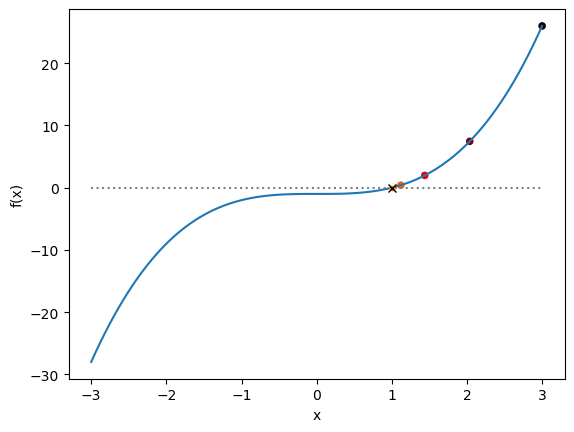

In [46]:
def f(x):
    return x**3 - 1

def df(x):
    return 3 * x**2

x0 = 3.
print("...running scipy netwon")
root = optimize.newton(f, x0, fprime=df)

print("...running my own netwon")
myroot, myfroot, xstory, fstory, _ = gradient_code.newton_root(f, df, x0, tol_f=1e-5, max_iter=50)

xs = np.linspace(-3,3,100)

plt.plot(xs, f(xs));
plt.hlines(y=0, xmin=xs[0], xmax=xs[-1], ls=":", color="gray")
plt.plot(root, f(root), '.');

plt.plot(myroot, myfroot, 'x', color="black");
plt.scatter(xstory, fstory, s=20, c=np.linspace(0, 255, len(xstory)), cmap="hot");

plt.xlabel('x')
plt.ylabel('f(x)');

### Newton method for optimization

#### 1. An example with a scalar function

...running scipy netwon
...running my own netwon
it 9 norm: 1.2204972062384334e-09
tol_x reached - solution found at it: 9


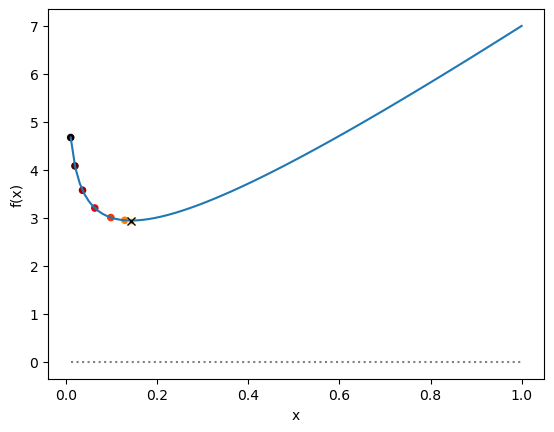

In [47]:
def f(x):
    return 7. * x - np.log(x)

def df(x):
    return 7. - 1. / x

def ddf(x):
    return 1. / x**2

x0 = 0.01 # try out 0.1 and 1. -> the last case will lead to nonsensical results out of the support of the log
print("...running scipy netwon")
try:
    root = optimize.newton(df, x0, fprime=ddf)
except:
    print("optimize.newton encountered a singularity")

print("...running my own netwon")
myroot, myfroot, xstory, fstory, intfstory = gradient_code.newton_root(df, ddf, x0, intf=f, tol_f=None, tol_x=1e-5, max_iter=100)

xs = np.linspace(1e-2, 1., 100)

plt.plot(xs, f(xs));
plt.hlines(y=0, xmin=xs[0], xmax=xs[-1], ls=":", color="gray")
plt.plot(root, f(root), '.');

plt.plot(myroot, f(myroot), 'x', color="black");
plt.scatter(xstory, intfstory, s=20, c=np.linspace(0, 255, len(xstory)), cmap="hot");

plt.xlabel('x')
plt.ylabel('f(x)');

#### 2. An example with a quadratic function in two dimensions

The exactness of the approximation for a quadratic function makes the method converge immediately.

Note that the Hessian selects "optimal learning rates" in each dimension.

it 2 norm: 0.0
tol_x reached - solution found at it: 2


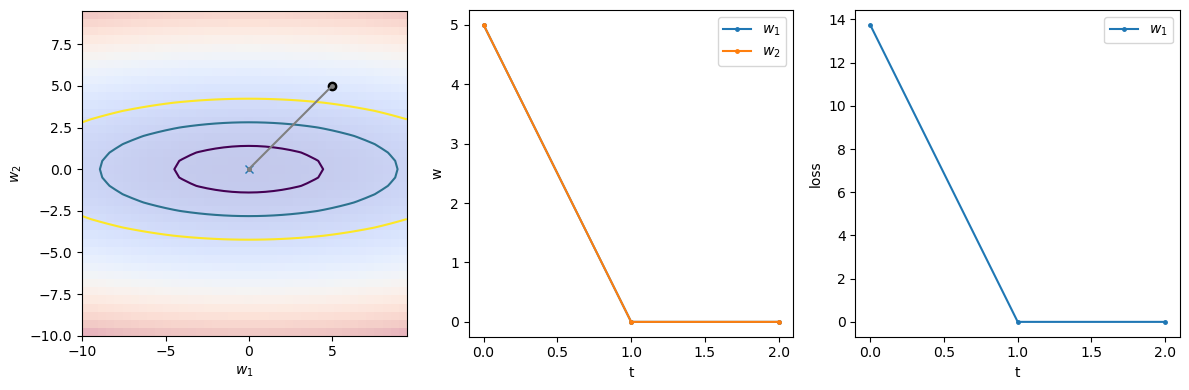

In [49]:
# define gradient function
def dloss(w):
    return np.array([lambdas[0] * w[0], lambdas[1] * w[1]])

# define hessian function - to be used as Jacobian in Newton method
def ddloss(w):
    return np.diag([lambdas[0], lambdas[1]])

w0 = np.array([5., 5.])
myroot, myfroot, wstory, fstory, intfstory = gradient_code.newton_root(dloss, ddloss, w0, intf=loss, tol_f=None, tol_x=1e-5, max_iter=50)

plotting_utility(E_quad, wrange, np.stack(wstory), np.stack(intfstory), minimizer=[0,0], label="w")

## Line search

Another solution is line optimization:

$$w_1=w_0+\lambda_0 d_0,\quad\quad d_0=-\nabla E(w_0)$$$\lambda_0>0$ is found by a one-dimensional optimization:$$0=\frac{\partial}{\partial \lambda_0}E(w_0+\lambda_0 d_0)=d_0 \cdot \nabla E(w_1)=d_0 \cdot d_1$$

Therefore, **subsequent search directions are orthogonal**.

#### Example:

Let's consider again $$E(w) = \frac{\lambda_1 w_1^2 + \lambda_1 w_2^2}{2}$$

with our usual starting point `w0=(5, 5)`

One (_i.e. a student of this course_) can (_and will_) easily find a linear equation for the optimal $\lambda$.

In [50]:
w0 = np.array([5., 5.])

In [ ]:
# solution for one step: you'll be asked to check these results in Ex 4.2
d0 = np.array([-0.5, -5.])
lopt = 1.008991008991009
w1 = np.array([ 4.4955045 , -0.04495504])
d1 = np.array([-0.44955045,  0.04495504])
print("d0 @ d1:", d0 @ d1) # check d0 and d1 directions are orthogonal

In [ ]:
# compute function along the negative gradient directions
ls0 = np.linspace(0, 3, 200)
w0_line = w0 + ls0[:,None] * d0
loss_line_w0 = np.zeros_like(ls0)
for iw, w in enumerate(w0_line):
    loss_line_w0[iw] = loss(w)

ls1 = np.linspace(0, 10, 200)
w1_line = w1 + ls1[:,None] * d1
loss_line_w1 = np.zeros_like(ls1)
for iw, w in enumerate(w1_line):
    loss_line_w1[iw] = loss(w)

plt.figure(figsize=(12,4))

plt.subplot(131)
plt.plot(w0[0], w0[1], '.')
plt.imshow(E_quad, extent=[wrange[0], wrange[-1], wrange[0], wrange[-1]], cmap="coolwarm", alpha=0.3)
plt.contour(E_quad, levels=[1,4,9], extent=[wrange[0], wrange[-1], wrange[0], wrange[-1]])
plt.scatter(w0_line[:,0], w0_line[:,1], c=loss_line_w0 / loss_line_w0.max(), edgecolors='none', cmap="coolwarm", s=3)
plt.xlabel("$w_1$")
plt.ylabel("$w_2$");

plt.subplot(132)
plt.plot(ls0[0], loss_line_w0[0], '.')
plt.plot(lopt, loss(w0 + lopt * d0), '.', c='black')
plt.scatter(ls0, loss_line_w0, c=loss_line_w0 / loss_line_w0.max(), edgecolors='none', cmap="coolwarm", s=3);
plt.xlabel("$\lambda$")
plt.ylabel("$E(w_0 + \lambda d_0)$");

plt.subplot(133)
ilopt = np.argmin(np.abs(ls0 - lopt))
plt.plot(w0[0], w0[1], '.')
plt.plot(w1[0], w1[1], '.', c='black')
plt.imshow(E_quad, extent=[wrange[0], wrange[-1], wrange[0], wrange[-1]], cmap="coolwarm", alpha=0.3)
plt.contour(E_quad, levels=[1,4,9], extent=[wrange[0], wrange[-1], wrange[0], wrange[-1]])
plt.scatter(w0_line[:ilopt,0], w0_line[:ilopt,1], c=loss_line_w0[:ilopt] / loss_line_w0.max(),
            vmin=0, vmax=1, edgecolors='none', cmap="coolwarm", s=3)
plt.scatter(w1_line[:,0], w1_line[:,1], c=loss_line_w1 / loss_line_w1.max(), edgecolors='none', cmap="coolwarm", s=3)
plt.xlabel("$w_1$")
plt.ylabel("$w_2$");

plt.tight_layout();

## _Bonus: Conjugate gradient descent_

Line search starts at $w_0$ and achieves:
$$w_1 \quad \text{such that}\quad \nabla E(w_1)\cdot d_0=0$$$$w_2 \quad \text{such that} \quad \nabla E(w_2) \cdot d_1=0$$$$\ldots$$

We want to find a method that yields $\nabla E(w_2) \cdot d_1=0$ **and** $\nabla E(w_2) \cdot d_0=0$. We choose as the new direction a combination of the gradient and the old direction:
$$d'_1=-\nabla E(w_1)+\beta d_0$$

Line optimization $w_2=w_1 +\lambda_1 d_1'$ yields $\lambda_1>0$ such that $d'_1 \cdot \nabla E(w_2)=0$. The direction $d'_1$ is found by demanding that $\nabla E(w_2)\approx 0$ also in the old direction $d_0$:
$$0=d_0 \cdot \nabla E(w_2)\approx d_0 \cdot (\nabla E(w_1) + \lambda_1 H(w_1) d'_1)$$or$$d_0 H(w_1)d'_1=0$$
The subsequent search directions $d_0, d_1'$ are said to be **conjugate**. The conjugate directions can be computed without calculating the Hessian matrix, for instance using the **Polak-Ribiere rule**:

$$\beta = \frac{(\nabla E(w_1)-\nabla E(w_0))\cdot \nabla E(w_1)}{\|\nabla E(w_0)\|^2}$$For quadratic problems, it can be proven that this rule keeps the last $N$ directions all mutually conjugate:$$d_i^T H d_j =0\qquad i,j =1,\ldots,N$$

#### Proof:
We need $0=d_0^T H(w_1)d_1'$. We use $\nabla E(w_0)\approx \nabla E(w_1)+(w_0-w_1)^T H(w_1)=\nabla E(w_1)-\lambda_0 d_0^T H(w_1)$.
Then
$$0=\lambda_0 d_0^T H(w_1)d_1'=\left(\nabla E(w_1)-\nabla E(w_0)\right)\cdot \left(-\nabla E(w_1)+\beta d_0\right)= -\left(\nabla E(w_1)-\nabla E(w_0)\right)\cdot \nabla E(w_1)+\beta \|\nabla E(w_0)\|^2$$where in the last step we used that $d_0\cdot \nabla E(w_1)=0$.

## Stochastic gradient descent (SGD)

Denote the training error:
$$E(w)=\frac{1}{P}\sum_\mu E_\mu(w)$$We want to find the solution of:$$\nabla E(w)=\frac{1}{P}\sum_\mu \nabla E_\mu(w)=0$$

One way to make the gradient computation less costly for large dataset is to only use a subset (or **batch**) $\mathcal{B}$ of training patterns when computing $\nabla E$:

$$w^{t+1}=w^{t}-\frac{\eta_{t}}{\left|\mathcal{B}\right|}\sum_{\mu\in\mathcal{B}}\nabla E_{\mu}$$

where $\left|\mathcal{B}\right|$ has been introduced to normalize with the total number of patterns in a batch, and we considered a learning rate $\eta_t$ that can generically depend on time.

SGD results in a stochastic dynamics in $w$ that can help to escape local minima.

## Robbins-Monro (RM)

Consider the $n$-dimensional problem of finding $x=(x_1,\ldots,x_n)$ such that:
$$M_i(x)=a_i$$

where
$$M_i(x)=\sum_\mu p_\mu N_{i\mu}(x)$$

and $N_{i\mu}(x)$ is some non-linear function, $p_\mu>0$ is a probability distribution ($\sum_\mu p_\mu=1$), and $a_i$ is a constant.

The method of **stochastic approximation**, originally due to Robbins and Monro (1951), proceeds as follows:
* Initialize $x^0$ randomly
* For $t=0,\ldots$, choose $\mu\sim p_\mu$

  update:
    $$x^{t+1}_i=x^{t}_i + \eta_t (a_i-N_{i\mu}(x^{t}))$$If $M_i(x)=\nabla_i E$ and $E$ is convex, and $x^*$ is the unique solution ($M_i(x^*)=a_i$), then one can prove that $\|x^t - x^*\|^2\to 0$, provided that:$$\sum_{t=1}^\infty \eta_t=\infty\qquad \sum_{t=1}^\infty \eta_t^2< \infty$$

for instance using a _learning rate scheduling_ $\eta_t=1/t$.

#### An example of RM

Inspired from: https://stats.stackexchange.com/questions/514680/root-finding-via-robbins-monro-method-a-real-and-simple-example

Consider the random function

$$ f(x) = \frac{1}{1+e^{-\frac{x}{2}}} - \frac{1}{2} + u$$

obtained by adding Gaussian noise $u$ to a translated sigmoid. Experiment with different gain functions $\eta_t = 1/t^b$

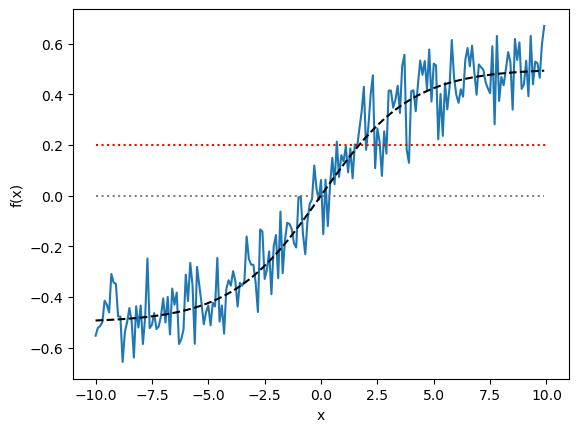

In [94]:
def f(x, noise = 0.1):
    av = 1. / (1. + np.exp(-0.5 * x)) - 0.5
    if isinstance(x, (np.ndarray)):
        return av + np.random.randn(*x.shape) * noise
    else:
        return av + np.random.randn() * noise

xs = np.arange(-10,10,0.1)
plt.plot(xs, f(xs))
plt.plot(xs, f(xs, noise=0), '--', c='black');
plt.hlines(y=0, xmin=xs[0], xmax=xs[-1], color='gray', ls=':');
plt.xlabel('x')
plt.ylabel('f(x)');

a = 0.2
plt.hlines(y=a, xmin=-10, xmax=10, ls=':', color='red');

In [95]:
# define a minimal Robbins-Monro routine
def rm(fun, eta_fun, a, x0, max_iter = 1000):
    x_history = np.zeros(max_iter)
    x = x0
    for it in range(1, max_iter + 1):
        x_history[it-1] = x
        eta = eta_fun(it)
        x = x + eta * (a - fun(x))
    return x, x_history

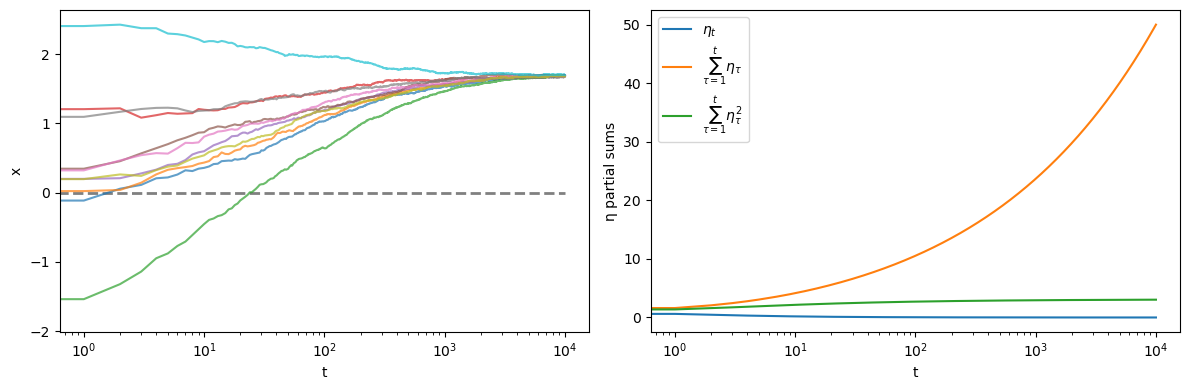

In [108]:
# run RM for different values of b a visualize the optimization dynamics from various initial conditions

max_iter = 10000
b = 0.7 # try very small b and also b > 1 and look at convergence behavior

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hlines(y=0, xmin=0, xmax=max_iter, color='gray', ls='--', lw=2);
for sample in range(10):
    x0 = np.random.randn()
    x, x_history = rm(f, lambda t : 1/t**b, a, x0, max_iter=max_iter)
    plt.plot(x_history, alpha=0.7)
plt.xlabel('t')
plt.ylabel('x')
plt.xscale('log')

plt.subplot(122)
ts = np.arange(1, max_iter + 1)
etas = 1/ts**b
plt.plot(etas, label='$η_t$');
plt.plot(etas.cumsum(), label=r'$\sum_{\tau=1}^t \eta_\tau$');
plt.plot((etas**2).cumsum(), label=r'$\sum_{\tau=1}^t \eta^2_\tau$');
plt.xscale('log')
plt.xlabel('t')
plt.ylabel('η partial sums')
plt.legend();

plt.tight_layout();

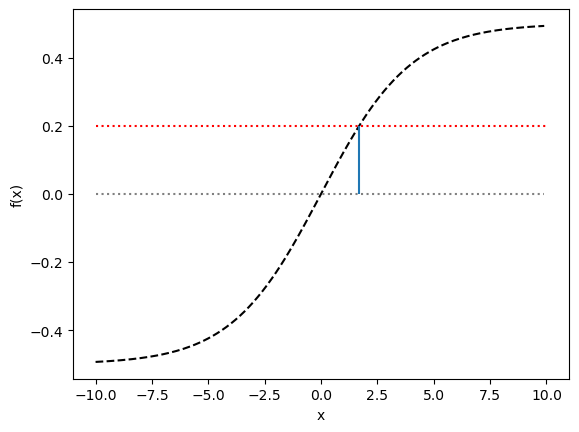

In [109]:
xs = np.arange(-10,10,0.1)
plt.plot(xs, f(xs, noise=0), '--', c='black');
plt.hlines(y=0, xmin=xs[0], xmax=xs[-1], color='gray', ls=':');
plt.xlabel('x')
plt.ylabel('f(x)');

a = 0.2
plt.hlines(y=a, xmin=-10, xmax=10, ls=':', color='red');
plt.vlines(x=x, ymin=0, ymax=f(x,noise=0));

#### Another classic example of RM: running average

Consider a stream of values $x_t$ from a Normal distribution. The problem of estimating the mean can be cast as that of finding the following root:

$$E\left[\mu - x_t\right] = 0$$

via the update rule

$$\mu_{t+1} = \mu_t - a_t \left( \mu_t - x_t\right) $$

or equivalently, and more familiarly:

$$\mu_{t+1} = \mu_t \left(1 - a_t \right) + x_t $$

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.hist(np.random.randn(10000), bins="auto", density=True, alpha=0.5)
plt.vlines(x=0, ymin=0, ymax=1/np.sqrt(2*np.pi), ls='--', color='gray')
plt.xlabel('x')
plt.ylabel('p(x)')

plt.subplot(122)
mu0 = np.random.randn()
mu, mu_history = rm(lambda x: x - np.random.randn(), lambda t : 1/t**0.6, 0., mu0, max_iter=max_iter)
plt.plot(mu_history, alpha=1);
plt.xlabel('t')
plt.ylabel('mu')

plt.tight_layout();

## Back to stochastic gradient descent

In the case where a single pattern is chosen for each weight update in stochastic gradient descent, we have an instance of a RM problem with:
$$p_\mu=\frac{1}{P}\qquad a_i=0\qquad N_{i\mu}(w)=\nabla_i E_\mu(w)$$

Thus SGD converges to the optimal solution provided $\eta_t$ is lowered appropriately and $E$ is convex.

# <center> Assigments </center>

#### Ex 4.1

Linear regression is one of the few examples where the minimization of the loss function can be worked out exactly. In this exercise you will check that gradient descent converges to the right minimizer.

Generate $P=100$ random vectors $x^\mu$ in $N=10$ dimension, with $x_i^\mu$ i.i.d. normally distributed, and their corresponding Gaussian distributed outputs $t^\mu$.

The objective is to learn a linear model
$$y(x, w)=\sum_{j=1}^N w_j x_j$$

The best parameters $w$ are found by minimizing:
$$E(w) =\frac{1}{2P}\sum_{\mu=1}^P \left[t^\mu - y(x^\mu, w)\right]^2$$

which, as we saw in an earlier lecture, can be considered as a likelihood maximization under a Gaussian model. Proceed as follows:

1. compute the gradient and the Hessian of the loss function $E$;
2. find the solution analytically;
3. highlight the relation between the uniqueness of solutions and the Hessian - discuss possible ways to solve the problem in the case where the solution is not unique;
4. implement gradient descent and show that it converges to the solutions found in point 2.

#### Ex 4.2

Fill in the missing steps in the **Example** of section **Line Search**:
* provide an analytical expression for `lopt`,  `w1` and `d1`;
* check your results using a scalar minimization routine like the [Golden-section](https://en.wikipedia.org/wiki/Golden-section_search) method along the lines of [`scipy.optimize.golden`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.golden.html). You might want to implement it yourself for later use in **Ex 4.3.4**;
* check the correctness of the points in the plot.

#### Ex 4.3

In this exercise you will implement a number of optimization algorithm to classify digits in the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset using logistic regression, with the loss function:

$$E(w)=-\frac{1}{P}\sum_{\mu=1}^P\left[t^\mu \log y(x^\mu,w)+(1-t^\mu)\log (1-y(x^\mu,w))\right]$$

The MNIST dataset contains 70000 images of digits from 0 to 9.

Proceed as follows:
* Download the dataset as explained below.
* Select the images of digits **3** and **7** for a two-class classification problem. You will find a total of 14434 images.
* Split the previously obtained set in two parts: 80% for the training set and 20% for testing.
* The raw data consists of pixel intensities from 0 to 255. Standardize the dataset so that the global pixel average is zero and the std is 1.
* Derive the gradient and Hessian for Logistic regression and implement the algorithms below. In the derivation, you will find the following property of the sigmoid function useful (_prove it!_):

$$\frac{d\sigma(x)}{dx}=\sigma(x) (1-\sigma(x))$$

which is nothing but the celebrated logistic differential equation, popular in the modeling of [population growth](https://en.wikipedia.org/wiki/Population_model).

For each algorithm, produce the requested output and share all the code. Make sure the code is reproducible so we can easily run it and check the results.

If optimization is too slow, feel free to report your results with a smaller dataset, by keeping only a subset of the original images.

There are a number of ways you can get the MNIST dataset. One option is to use scikit-learn:

In [16]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)

X, y = mnist["data"].astype(float), mnist["target"].astype(float) # Note: images in X are flattened 28 x 28 = 784

Another option is to get started with [pytorch](https://pytorch.org/), which we will use to train deep networks. You may want to go through this introductory [tutorial](https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

You can use [`torch.utils.data.DataLoader`](https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) to extract the entire dataset from [`torchvision.datasets.MNIST`](https://docs.pytorch.org/vision/0.8/datasets.html#mnist).

##### 4.3.1

* Implement gradient descent to minimize the loss function $E$ for logistic regression.
* Produce plots showing how $E$ decreases with iterations on both the training and test sets. Note that the training error should always decrease, but the test error may not.
* Test the effect of different values for the learning rate $\eta$.
* Experiment with **early stopping**. Divide your training set into an 80% training set and a 20% validation set (you are not allowed to use the test set to decide when to stop). Train on this reduced training set and monitor the error on both the training and validation sets. Stop the training if/when the validation error increases. Report the error on the test set.

##### 4.3.2

* Add momentum with strength $\alpha$ to your gradient rule.
* Produce plots of how $E$ decreases with iterations on both the training and test sets.
* Test the effect of different values for $\alpha$ and $\eta$.

##### 4.3.3

Add a **weight decay** term to $E$ (you may notice that momentum induces a slight overfitting):
$$E\left(w\right)=-\frac{1}{P}\sum_{\mu=1}^{P}\left[t^{\mu}\log y^{\mu}+\left(1-t^{\mu}\right)\log\left(1-y^{\mu}\right)\right]+\frac{\lambda}{2N}\sum_{i=0}^{N}w_{i}^{2}$$

Using $\lambda=0.1$ and the momentum method, report the final loss (without the regularization term) on both training and test sets after convergence, along with the number of iterations.

##### 4.3.3

We'll now use this problem (with $\lambda=0.1$) and the results from gradient descent with momentum to compare with other methods.

##### Newton method

Implement the Newton method for the logistic regression problem with weight decay. Produce plots showing how $E$ decreases with iterations on both the training and test sets. Discuss the compromise between number of iteration and computational burden.

##### Line search

Implement the gradient method with a **line search**: in each iteration, compute the gradient at the current $w$: $d=-\nabla E(w)$, then numerically find the value of $\gamma > 0$ that minimizes $E(w+\gamma d)$. The main challenge is defining the initial interval for the search. Produce plots of how $E$ decreases with iterations on the training and test sets.

##### Stochastic gradient descent

Implement the SGD method using a constant learning rate $\eta$ and mini-batch sizes. Produce plots showing how $E$ decreases with iterations on both the training and test sets for different values of $\eta$ and the size of each batch.